# Joint Course  

In [1]:
try
    using Gmsh: gmsh, Gmsh 
catch
    using gmsh
end 

## Section 1: OpenCascade - GMSH for Definition of Actuator - Wish to count number of boundary nodes

In [6]:
gmsh.finalize()

In [7]:
?gmsh.model.mesh.getNodes

```
gmsh.model.mesh.getNodes(dim = -1, tag = -1, includeBoundary = false, returnParametricCoord = true)
```

Get the nodes classified on the entity of dimension `dim` and tag `tag`. If `tag` < 0, get the nodes for all entities of dimension `dim`. If `dim` and `tag` are negative, get all the nodes in the mesh. `nodeTags` contains the node tags (their unique, strictly positive identification numbers). `coord` is a vector of length 3 times the length of `nodeTags` that contains the x, y, z coordinates of the nodes, concatenated: [n1x, n1y, n1z, n2x, ...]. If `dim` >= 0 and `returnParamtricCoord` is set, `parametricCoord` contains the parametric coordinates ([u1, u2, ...] or [u1, v1, u2, ...]) of the nodes, if available. The length of `parametricCoord` can be 0 or `dim` times the length of `nodeTags`. If `includeBoundary` is set, also return the nodes classified on the boundary of the entity (which will be reparametrized on the entity if `dim` >= 0 in order to compute their parametric coordinates).

Return `nodeTags`, `coord`, `parametricCoord`.

Types:

  * `nodeTags`: vector of sizes
  * `coord`: vector of doubles
  * `parametricCoord`: vector of doubles
  * `dim`: integer
  * `tag`: integer
  * `includeBoundary`: boolean
  * `returnParametricCoord`: boolean


In [8]:
#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 

#..step-1: create and name core domain.. 
out_tag  = gmsh.model.occ.add_rectangle(-0.05, 0, zc, 0.1, 0.0405)
inn_tag  = gmsh.model.occ.add_rectangle(-0.04, 0.01, zc, .08, .0205)
gap_tag  = gmsh.model.occ.add_rectangle(-0.021, 0.0305, zc, .042, .01)
core_tag = gmsh.model.occ.cut([(2, out_tag)], [(2, inn_tag)])
core_tag = gmsh.model.occ.cut([(2, out_tag)], [(2, gap_tag)])
gmsh.model.setEntityName(dim,core_tag[1][1][2],"core")

#..step-2: create and name mover domain.. 
mover_tag = gmsh.model.occ.add_rectangle(-0.020, 0.0305, zc, .04, .01)
gmsh.model.setEntityName(dim,mover_tag,"mover")

#..step-3: create and name permanent magnet domain.. 
pm_tag    = gmsh.model.occ.add_rectangle(-0.010, 0.01, zc, .02, .02)
gmsh.model.setEntityName(dim,mover_tag,"pm")

#..step-4: create and name left coil up and left coil down.. 
left_coil_up_tag  = gmsh.model.occ.add_rectangle(-0.04, 0.01, zc, 0.03, 0.01)
gmsh.model.setEntityName(dim,left_coil_up_tag,"left-coil-up")
left_coil_dw_tag  = gmsh.model.occ.copy([(2, left_coil_up_tag)])
gmsh.model.occ.translate(left_coil_dw_tag, 0, -0.02, 0)
gmsh.model.setEntityName(dim,left_coil_dw_tag[1][2],"left-coil-dw")

#..step-5: create and name right coil up and right coil down.. 
right_coil_up_tag  = gmsh.model.occ.add_rectangle(0.01, 0.01, zc, 0.03, 0.01)
gmsh.model.setEntityName(dim,right_coil_up_tag,"right-coil-up")
right_coil_dw_tag  = gmsh.model.occ.copy([(2, right_coil_up_tag)])
gmsh.model.occ.translate(right_coil_dw_tag, 0, -0.02, 0)
gmsh.model.setEntityName(dim,right_coil_dw_tag[1][2],"right-coil-dw")

#..step-6: create and name air domain 
air_tag = gmsh.model.occ.add_rectangle(-0.08, -0.03, zc, 0.16, 0.09)
gmsh.model.setEntityName(dim,air_tag,"air")

#..step-7: synchronize  model (required here in order for model.getEntities() to work properly) 
gmsh.model.occ.synchronize()

#..step-8: get entities  
entities = gmsh.model.getEntities() # see documentation of getEnties 

#..step-9: subtract core from air domain 
for e in entities
    dim  = e[1]
    tag  = e[2]
    name = gmsh.model.getEntityName(dim,tag)

    if ((name=="core")||(name=="mover")||(name=="pm")||(name=="left-coil-up")||(name=="left-coil-dw")||(name=="right-coil-up")||(name=="right-coil-dw"))
        copy = gmsh.model.occ.copy(e)
        difference = gmsh.model.occ.cut([(dim, air_tag)],e) 
    end 
    
end

#..step-10: synchronize  model
gmsh.model.occ.synchronize()

#..step-11: assign physical groups
bottomtag = gmsh.model.add_physical_group(1, [172], -1, "bottom")
lefttag   = gmsh.model.add_physical_group(1, [173], -1, "left")
righttag  = gmsh.model.add_physical_group(1, [174], -1, "right")
toptag    = gmsh.model.add_physical_group(1, [175], -1, "top")
magnettag = gmsh.model.add_physical_group(2, [3], -1, "magnet")
airtag    = gmsh.model.add_physical_group(2, [8], -1, "air")
coretag   = gmsh.model.add_physical_group(2, [9], -1, "core")
movertag  = gmsh.model.add_physical_group(2, [10], -1, "mover")
left_coil_uptag  = gmsh.model.addPhysicalGroup(2, [11], -1, "left_coil_up")
left_coil_dwtag  = gmsh.model.addPhysicalGroup(2, [12], -1, "left_coil_dw")
right_coil_uptag = gmsh.model.addPhysicalGroup(2, [13], -1, "right_coil_up")
right_coil_dwtag = gmsh.model.addPhysicalGroup(2, [14], -1, "right_coil_dw")

#..step-1: synchronize  model (required here in order for mesh generation to work properly)
gmsh.model.occ.synchronize()

gmsh.option.setNumber("Mesh.MeshSizeMax",0.001)

gmsh.model.mesh.generate(dim)

#..if true, write mesh to file for further processing
if (true) gmsh.write("actuator.msh") end 

#..if true, visualize mesh through the GUI 
#if (true) gmsh.fltk.run() end 

#..finalize GMSH
gmsh.finalize()

In [11]:
gmsh.finalize()

In [12]:
#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 

#..step-1: create and name core domain.. 
out_tag  = gmsh.model.occ.add_rectangle(-0.05, 0, zc, 0.1, 0.0405)
inn_tag  = gmsh.model.occ.add_rectangle(-0.04, 0.01, zc, .08, .0205)
gap_tag  = gmsh.model.occ.add_rectangle(-0.021, 0.0305, zc, .042, .01)
core_tag = gmsh.model.occ.cut([(2, out_tag)], [(2, inn_tag)])
core_tag = gmsh.model.occ.cut([(2, out_tag)], [(2, gap_tag)])
gmsh.model.setEntityName(dim,core_tag[1][1][2],"core")

#..step-2: create and name mover domain.. 
mover_tag = gmsh.model.occ.add_rectangle(-0.020, 0.0305, zc, .04, .01)
gmsh.model.setEntityName(dim,mover_tag,"mover")

#..step-3: create and name permanent magnet domain.. 
pm_tag    = gmsh.model.occ.add_rectangle(-0.010, 0.01, zc, .02, .02)
gmsh.model.setEntityName(dim,mover_tag,"pm")

#..step-4: create and name left coil up and left coil down.. 
left_coil_up_tag  = gmsh.model.occ.add_rectangle(-0.04, 0.01, zc, 0.03, 0.01)
gmsh.model.setEntityName(dim,left_coil_up_tag,"left-coil-up")
left_coil_dw_tag  = gmsh.model.occ.copy([(2, left_coil_up_tag)])
gmsh.model.occ.translate(left_coil_dw_tag, 0, -0.02, 0)
gmsh.model.setEntityName(dim,left_coil_dw_tag[1][2],"left-coil-dw")

#..step-5: create and name right coil up and right coil down.. 
right_coil_up_tag  = gmsh.model.occ.add_rectangle(0.01, 0.01, zc, 0.03, 0.01)
gmsh.model.setEntityName(dim,right_coil_up_tag,"right-coil-up")
right_coil_dw_tag  = gmsh.model.occ.copy([(2, right_coil_up_tag)])
gmsh.model.occ.translate(right_coil_dw_tag, 0, -0.02, 0)
gmsh.model.setEntityName(dim,right_coil_dw_tag[1][2],"right-coil-dw")

#..step-6: create and name air domain 
air_tag = gmsh.model.occ.add_rectangle(-0.08, -0.03, zc, 0.16, 0.09)
gmsh.model.setEntityName(dim,air_tag,"air")

#..step-7: synchronize  model (required here in order for model.getEntities() to work properly) 
gmsh.model.occ.synchronize()

#..step-8: get entities  
entities = gmsh.model.getEntities() # see documentation of getEnties 

#..step-9: subtract core from air domain 
for e in entities
    dim  = e[1]
    tag  = e[2]
    name = gmsh.model.getEntityName(dim,tag)

    if ((name=="core")||(name=="mover")||(name=="pm")||(name=="left-coil-up")||(name=="left-coil-dw")||(name=="right-coil-up")||(name=="right-coil-dw"))
        copy = gmsh.model.occ.copy(e)
        difference = gmsh.model.occ.cut([(dim, air_tag)],e) 
    end 
    
end

#..step-10: synchronize  model
gmsh.model.occ.synchronize()

#..step-11: assign physical groups
bottomtag = gmsh.model.add_physical_group(1, [172], -1, "bottom")
lefttag   = gmsh.model.add_physical_group(1, [173], -1, "left")
righttag  = gmsh.model.add_physical_group(1, [174], -1, "right")
toptag    = gmsh.model.add_physical_group(1, [175], -1, "top")
magnettag = gmsh.model.add_physical_group(2, [3], -1, "magnet")
airtag    = gmsh.model.add_physical_group(2, [8], -1, "air")
coretag   = gmsh.model.add_physical_group(2, [9], -1, "core")
movertag  = gmsh.model.add_physical_group(2, [10], -1, "mover")
left_coil_uptag  = gmsh.model.addPhysicalGroup(2, [11], -1, "left_coil_up")
left_coil_dwtag  = gmsh.model.addPhysicalGroup(2, [12], -1, "left_coil_dw")
right_coil_uptag = gmsh.model.addPhysicalGroup(2, [13], -1, "right_coil_up")
right_coil_dwtag = gmsh.model.addPhysicalGroup(2, [14], -1, "right_coil_dw")

#..step-1: synchronize  model (required here in order for mesh generation to work properly)
gmsh.model.occ.synchronize()

gmsh.option.setNumber("Mesh.MeshSizeMax",0.001)

gmsh.model.mesh.generate(dim)

#..if true, write mesh to file for further processing
if (true) gmsh.write("actuator.msh") end 

#..if true, visualize mesh through the GUI 
#if (true) gmsh.fltk.run() end 

#..finalize GMSH
#gmsh.finalize()

In [23]:
nodeTags2, nodeCoords, nodeParams = gmsh.model.mesh.getNodes(1,172)
display(length(nodeTags2))
nodeTags3, nodeCoords, nodeParams = gmsh.model.mesh.getNodes(1,173)
display(length(nodeTags3))
nodeTags4, nodeCoords, nodeParams = gmsh.model.mesh.getNodes(1,174)
display(length(nodeTags4))
nodeTags5, nodeCoords, nodeParams = gmsh.model.mesh.getNodes(1,175)
display(length(nodeTags5))

159

89

89

159

In [33]:
using Plots 

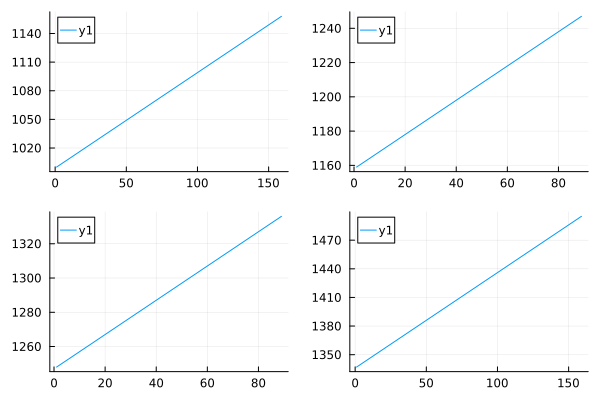

In [34]:
p2 = plot(Int64.(nodeTags2))
p3 = plot(Int64.(nodeTags3))
p4 = plot(Int64.(nodeTags4))
p5 = plot(Int64.(nodeTags5))
plot(p2,p3,p4,p5,layout=(2,2))

### Core, Mover and Air 

In [151]:
gmsh.finalize()

Error   : Gmsh has not been initialized
Error   : Gmsh has not been initialized


LoadError: UndefVarError: `error` not defined

In [150]:
#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 

#..step-1: create core domain.. 
out_tag  = gmsh.model.occ.add_rectangle(-0.05, 0, zc, 0.1, 0.0405)
inn_tag  = gmsh.model.occ.add_rectangle(-0.04, 0.01, zc, .08, .0205)
gap_tag  = gmsh.model.occ.add_rectangle(-0.021, 0.0305, zc, .042, .01)
core_tag = gmsh.model.occ.cut([(2, out_tag)], [(2, inn_tag)])
core_tag = gmsh.model.occ.cut([(2, out_tag)], [(2, gap_tag)])
gmsh.model.setEntityName(dim,core_tag[1][1][2],"core")

#..step-2: create mover domain.. 
mover_tag = gmsh.model.occ.add_rectangle(-0.020, 0.0305, zc, .04, .01)
gmsh.model.setEntityName(dim,mover_tag,"mover")

#..step-3: create air domain 
air_tag = gmsh.model.occ.add_rectangle(-0.08, -0.03, zc, 0.16, 0.09)
gmsh.model.setEntityName(dim,air_tag,"air")

#..step 4: synchronize  model (required here in order for model.getEntities() to work properly) 
gmsh.model.occ.synchronize()

#..step-5: get entities  
entities = gmsh.model.getEntities() # see documentation of getEnties 

#..step-6: subtract core from air domain 
for e in entities
    dim  = e[1]
    tag  = e[2]
    name = gmsh.model.getEntityName(dim,tag)

    if ((name=="core")||(name=="mover"))
        copy = gmsh.model.occ.copy(e)
        difference = gmsh.model.occ.cut([(dim, air_tag)],e) 
    end 
    
end 

#..step-7: synchronize  model (required here in order for mesh generation to work properly)
gmsh.model.occ.synchronize()

gmsh.option.setNumber("Mesh.MeshSizeMax",0.001)

gmsh.model.mesh.generate(dim)

#..if true, visualize mesh through the GUI 
if (true) gmsh.fltk.run() end 

#..finalize GMSH
gmsh.finalize()

2026-01-25 16:34:33.243 julia[29412:2454808] _TIPropertyValueIsValid called with 16 on nil context!
2026-01-25 16:34:33.243 julia[29412:2454808] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2026-01-25 16:34:33.243 julia[29412:2454808] Text input context does not respond to _valueForTIProperty:


### Core and Air 

Here we assume $\Omega_1$ to be the resuls of various operations.  

In [134]:
gmsh.finalize()

Error   : Gmsh has not been initialized
Error   : Gmsh has not been initialized


LoadError: UndefVarError: `error` not defined

In [143]:
#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 

#..step-1: create the core domain.. 
out_tag  = gmsh.model.occ.add_rectangle(-0.05, 0, zc, 0.1, 0.0405)
inn_tag  = gmsh.model.occ.add_rectangle(-0.04, 0.01, zc, .08, .0205)
gap_tag  = gmsh.model.occ.add_rectangle(-0.021, 0.0305, zc, .042, .01)
core_tag = gmsh.model.occ.cut([(2, out_tag)], [(2, inn_tag)])
core_tag = gmsh.model.occ.cut([(2, out_tag)], [(2, gap_tag)])
gmsh.model.setEntityName(dim,core_tag[1][1][2],"core")

#..step-2: create the air domain  
air_tag = gmsh.model.occ.add_rectangle(-0.08, -0.03, zc, 0.16, 0.09)
gmsh.model.setEntityName(dim,air_tag,"air")

#..step 3: synchronize  model (required here in order for model.getEntities() to work properly) 
gmsh.model.occ.synchronize()

#..step-4: get entities  
entities = gmsh.model.getEntities() # see documentation of getEnties 

#..step-5: subtract core from air domain 
for e in entities
    dim  = e[1]
    tag  = e[2]
    name = gmsh.model.getEntityName(dim,tag)

    if (name=="core")
        copy = gmsh.model.occ.copy(e)
        difference = gmsh.model.occ.cut([(dim, air_tag)],e) 
    end 
    
end 

#..step-6: synchronize  model (required here in order for mesh generation to work properly)
gmsh.model.occ.synchronize()

gmsh.option.setNumber("Mesh.MeshSizeMax",0.005)

gmsh.model.mesh.generate(dim)

#..if true, visualize mesh through the GUI 
if (true) gmsh.fltk.run() end 

#..finalize GMSH
gmsh.finalize()

### Two Inner Domains Using a Loop over Two-Dimensional Entities 

Assume $\Omega_1$ and $\Omega_1$ to be two inner domains (parts of the actuator) to be a subset of $\Omega_0$ (outer domain or air surrounding actuator). We wish to perform of union of $\Omega_1$, $\Omega_2$ and $\Omega_0 \setminus (\Omega_1 \cup \Omega_2)$ using the following steps: 

1. create inner domain $\Omega_1$ using the function <i>add_rectangle</i>. This function returns the tag as an Int32;
2. give a name to $\Omega_1$ using the function <i>setEntityName</i> allowing to identify $\Omega_1$ in a loop over two-dimensional entities;
3. repeat above twice, replacing $\Omega_1$ by $\Omega_2$ and $\Omega_0$, respectively;  
4. in a loop over two-dimensional entities $\Omega_1$ and $\Omega_2$
    * create a copy of $\Omega_i$ where $i=1$ and $i=2$ using the function <i>copy</i>. This function returns a tuple (dim,tag);
    * create the difference $\Omega_0 \setminus \Omega_i$ using the function <i>cut</i>

<b>Remarks</b>
1. pls. make sure to call <i>synchronize()</i> prior to calling <i>getEntities()</i>

In [74]:
gmsh.finalize()

Error   : Gmsh has not been initialized
Error   : Gmsh has not been initialized


LoadError: UndefVarError: `error` not defined

In [98]:
#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 

#..step-1: create first inner rectangle and sets its name   
inn_rect1 = gmsh.model.occ.add_rectangle(0.25, 0.25, zc, 0.25, 0.25)
gmsh.model.setEntityName(dim,inn_rect1, "inn_rect1")
#..step-2: create second inner rectangle and sets its name  
inn_rect2 = gmsh.model.occ.add_rectangle(0.75, 0.75, zc, 0.5, 0.5)
gmsh.model.setEntityName(dim,inn_rect2, "inn_rect2")
#..step-3: create outer rectangle and sets its name 
out_rect = gmsh.model.occ.add_rectangle(0, 0, zc, 2, 2)
gmsh.model.setEntityName(dim,out_rect, "out_rect")

gmsh.model.occ.synchronize()

#..step-4: loop over two-dimensional entities $\Omega_1$ and $\Omega_2$
entities = gmsh.model.getEntities() # see documentation of getEnties 

for e in entities
    dim  = e[1]
    tag  = e[2]
    name = gmsh.model.getEntityName(dim,tag)
    
    if ((dim == 2) && !(name=="out_rect"))
        display(name)
        copy = gmsh.model.occ.copy(e)
        difference = gmsh.model.occ.cut([(dim, out_rect)],e) 
    end 
    
end 

gmsh.model.occ.synchronize()

gmsh.option.setNumber("Mesh.MeshSizeMax",0.1)

gmsh.model.mesh.generate(dim)

#..if true, visualize mesh through the GUI 
if (true) gmsh.fltk.run() end 

#..finalize GMSH
gmsh.finalize() 

"inn_rect1"

"inn_rect2"

### Single Inner Domain Using occ.copy() and occ.cut() 

Assume $\Omega_1$ (inner domain or actuator) to be a subset of $\Omega_0$ (outer domain or air surrounding actuator). We wish to perform of union of $\Omega_1$ and $\Omega_0 \setminus \Omega_1$ using the following steps: 
1. create inner domain $\Omega_1$ using the function <i>add_rectangle</i>. This function returns the tag as an Int32;
2. create a copy of $\Omega_1$ using the function <i>copy</i>. This function returns a tuple (dim,tag). The copy is given a new tag. This copy needs to be created prior to cutting $\Omega_1$ away from $\Omega_0$; 
3. create outer domain $\Omega_0$  using the function <i>add_rectangle</i> again;
4. create the difference $\Omega_0 \setminus \Omega_1$ using the function <i>cut</i>. This function returns a vector of tuples (dim,tag). <b>Note that</b> the output is written to a new variable called <i>difference</i>;

<b>Remarks</b>
1. the function <i>cut</i> modifies its first input argument;
2. the function <i>cut</i> throws its second argument in the garbage (it is kept as output argument. Requires reformulation). This can be verified by giving the 2D surfaces names allows us to verify that the domain $\Omega_1$ is lost by the cut-operation; 
3. the output of the function <i>cut</i> is of type <i>Tuple{Vector{Tuple{Int32, Int32}}, Vector{Vector{Tuple{Int32, Int32}}}}</i>. The tag given to the output is thus given by <i>out[1][1][2]</i> 

In [96]:
gmsh.finalize()

Error   : Gmsh has not been initialized
Error   : Gmsh has not been initialized


LoadError: UndefVarError: `error` not defined

In [109]:
#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 

#..step-1: create inner rectangle and its copy  
inn_rect = gmsh.model.occ.add_rectangle(0.5, 0.5, zc, 1, 1)
gmsh.model.setEntityName(dim,inn_rect1,"inner-rectangle")
#..step-2: create a copy of the inner domain: order of these operations seems to matter 
copy = gmsh.model.occ.copy([(dim,inn_rect)])
gmsh.model.setEntityName(dim,copy[1][2],"inner-rectangle-copy")
#..step-3: create outer rectangle
out_rect = gmsh.model.occ.add_rectangle(0, 0, zc, 2, 2)
gmsh.model.setEntityName(dim,out_rect,"outer-rectangle")
#..step-4: create difference outer-domain - inner-domain  
difference = gmsh.model.occ.cut([(dim, out_rect)], [(dim, inn_rect)])

gmsh.model.occ.synchronize()

gmsh.model.mesh.generate(dim)

#..if true, visualize mesh through the GUI 
#if (true) gmsh.fltk.run() end 

#..step-5: loop over two-dimensional entities $\Omega_1$ and $\Omega_2$
entities = gmsh.model.getEntities() # see documentation of getEnties 

for e in entities
    dim  = e[1]
    tag  = e[2]
    name = gmsh.model.getEntityName(dim,tag)

    if ((dim == 2))
        display(name)
    end 
    
end 

#..finalize GMSH
gmsh.finalize() 

display(typeof(inn_rect))
display(inn_rect)
display(typeof(copy))
display(copy[1][1])
display(copy[1][2])
display(typeof(out_rect))
display(out_rect)
display(typeof(difference))
display(difference[1][1][1])
display(difference[1][1][2])

"inner-rectangle-copy"

"outer-rectangle"

Int32

1

Vector{Tuple{Int32, Int32}} (alias for Array{Tuple{Int32, Int32}, 1})

2

2

Int32

3

Tuple{Vector{Tuple{Int32, Int32}}, Vector{Vector{Tuple{Int32, Int32}}}}

2

3

## Section 2: Course Content 

### Block (1/3):Week 1 and 2 

1. Jianning: circuits. Current and voltages for interconnected coils. Initial value problem for coupled system of differential equations. Analytical solution methods? Time-stepping methods. Preriquisites to be specified. Reading material to be specified. Examples to be specified;
2. Domenico: fiels. Potential for electrical or magnetic fields. Boundary value problem for the Poisson equation. Post-processing for the inductance (and capacitance?). Analytical solution methods? Finite element methods. Preriquisites to be specified. Reading material to be specified. Example of coil-coil-air solved using sympy (analytical solution method - only linear material).
4. TMB: to be specified 

### Outdated: Preliminary Content Matter 

<b>Content</b>
1. Laplace and Poisson Equation for the Electrostatic Field in term of the electrical field potential. Material constitutive equations. Physical units;
2. electric energy density and magnetic energy density; 
3. (optional) Laplace and Poisson Equation for the Magnetostatic Field in terms of the scalar magnetic field potential. Material constitutive equations. Physical units;
4. double curl equation for the magnetic vector equation. Reduction to two-dimensional perpendicular current formulation;   
5. (optional): Reduction of double curl equation to to two-dimensional azimuthal current formulations; 
6. one-dimensional reference solutions: analytically, symbolically or built-in numerical tools;
7. one-dimensional coil-yoke-air problem: solve potential, post-process b-field, h-field, magnetic energy $W_m = \int_0^1 B_y(x) H_y(x) dx$, and compute inductance $L = 2 W_m/I^2$. Repeat with eddy currents, transient and magnetic saturation;  
8. two-dimensional reference solutions: analytically or built-in numerical tools;
9. Julia programminmg language   

<b>Provide Pointers to</b>
1. non-linear materials; 
2. eddy-current effects;
3. transient field computations; 

<b>Requires Input on</b>
1. material already available that can be reused (link here to courses in Q1 and Q2); 
2. how to compute inductance analytically or symbolically; 

### Block (2/3): Week 3 and 4

1. Jianning: state-space representation; 
2. Domenico: 2D FEM model for (1/2) two coils and core and (2/2) permanent magnet field in slotted machine. Poisson equation for magnetic vector potential component. Use implementation to explain concepts used.  Variational formulation. Galerkin spatial discretization. Element-by-element assembly. 
4. TBM: 

Assessment: 
1. derive the equations used in the model - derive the boundary conditions 
   
#### Outdated: One-Dimensional Finite Element Modeling 

<b>Content</b>
1. Problem formulation: ordinary differential equation supplied with boundary value problems;
2. Weak formulation, variational formulation, weighted residuals;
3. Mesh generation, finite element basis functions; 
4. Assembly mass matrix, stiffness matrix, load vector;
5. Linear system solve for finite element solution;
6. Post-processing; 

<b>Provide Pointers to</b>

<b>Requires Input on</b>
1. exact problem formulation;
2. details on computations of the inductance $L$ either using energy or flux and preferably both; 

### Block (3/3): (Week 5, 6 and 7)

1. Jianning: include mechanical variables in the output (observables) vector; 
2. Domenico: 2D FEM model for linear actuator 
3. (Poisson equation for magnetic vector potential component. Use implementation to explain concepts used.  Variational formulation. Galerkin spatial discretization. Element-by-element assembly.)
4. post-processing for forcec on the moving part; 
5. TBM: 

#### Outdated: Two-Dimensional Finite Element Modeling (adding air by union(air,air \setminus geometry) currently fials). 

<b>Content</b>
1. extend above from 1D (only $x$) to 2D (both $x$ and $y$); 

<b>Provide Pointers to</b>

<b>Requires Input on</b>
1. pre-cooking geometry definition and mesh generation;

## GMSH Manual 

<b>gmsh.model.occ.add_curve_loop</b>: add closed loops around circle. See e.g. L21 of [tq19.jl](https://gitlab.onelab.info/gmsh/gmsh/blob/gmsh_4_15_0/tutorials/julia/t19.jl#L21). Does <b>not</b> work for rectangles (because surface instead of loop). 

<b>gmsh.model.occ.add_surface_loop</b>: add closed loops around surface. Not yet seen in tutorials. Does not work for circle (because loop instead of surface). 

<b>gmsh.model.occ.add_surface_loop</b>: See L30 of [t16.jl](https://gitlab.onelab.info/gmsh/gmsh/blob/gmsh_4_15_0/tutorials/julia/t16.jl#L30). What happens in case the two seperate objects are formed? 

In [ ]:
?gmsh.model.occ.add_curve_loop

In [ ]:
?gmsh.model.occ.add_surface_loop

In [71]:
?gmsh.model.occ.cut

```
gmsh.model.occ.cut(objectDimTags, toolDimTags, tag = -1, removeObject = true, removeTool = true)
```

Compute the boolean difference between the entities `objectDimTags` and `toolDimTags` (given as vectors of (dim, tag) pairs) in the OpenCASCADE CAD representation. Return the resulting entities in `outDimTags`. If `tag` is positive, try to set the tag explicitly (only valid if the boolean operation results in a single entity). Remove the object if `removeObject` is set. Remove the tool if `removeTool` is set.

Return `outDimTags`, `outDimTagsMap`.

Types:

  * `objectDimTags`: vector of pairs of integers
  * `toolDimTags`: vector of pairs of integers
  * `outDimTags`: vector of pairs of integers
  * `outDimTagsMap`: vector of vectors of pairs of integers
  * `tag`: integer
  * `removeObject`: boolean
  * `removeTool`: boolean


## Examples from Ferrite.jl: How to add boundary labels? Which one-dimensional tags lie on the boundary? Use GridapGmsh? Use GUI to retrieve the edge labels? 

Ferrite tutorial as is.

<b>Label the boundary edges</b>

To view the boundary labels in the GUI, use "Open Quick Menu" (second symbol labeled as O in lower left corner) and toggle the edge labels to "on".  

In [10]:
gmsh.finalize()

Error   : Gmsh has not been initialized
Error   : Gmsh has not been initialized


LoadError: UndefVarError: `error` not defined

In [10]:
#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 

#..outer rectangle
rect_tag = gmsh.model.occ.add_rectangle(0, 0, 0, 1.1, 0.41)
#..inner circle 
circle_tag = gmsh.model.occ.add_circle(0.2, 0.2, 0, 0.05)
#..disk enclosured by circle 
circle_curve_tag = gmsh.model.occ.add_curve_loop([circle_tag])
circle_surf_tag = gmsh.model.occ.add_plane_surface([circle_curve_tag])
gmsh.model.occ.cut([(dim, rect_tag)], [(dim, circle_surf_tag)])

gmsh.model.occ.synchronize()

bottomtag = gmsh.model.model.add_physical_group(dim - 1, [6], -1, "bottom")
lefttag = gmsh.model.model.add_physical_group(dim - 1, [7], -1, "left")
righttag = gmsh.model.model.add_physical_group(dim - 1, [8], -1, "right")
toptag = gmsh.model.model.add_physical_group(dim - 1, [9], -1, "top")
holetag = gmsh.model.model.add_physical_group(dim - 1, [5], -1, "hole")
domaintag = gmsh.model.model.add_physical_group(dim , [1], -1, "omega")

# gmsh.option.setNumber("Mesh.MeshSizeMax",0.001)
entities = gmsh.model.getEntities()

gmsh.model.mesh.generate(dim)
if (true) gmsh.write("actuator.msh") end

#..if true, visualize mesh through the GUI 
if (true) gmsh.fltk.run() end 

#..finalize GMSH
gmsh.finalize()

Same as before, replacing circle by disk. 

In [53]:
# Modified Ferrite NS tutorial: replace circle by disk 

#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 

#..outer rectangle
rect_tag = gmsh.model.occ.add_rectangle(0, 0, 0, 1.1, 0.41)
#..inner disk 
disk_tag = gmsh.model.occ.add_disk(0.2, 0.2, 0, 0.05, 0.05)
#..difference between rectangle and disk  
gmsh.model.occ.cut([(dim, rect_tag)], [(dim, disk_tag)])

gmsh.model.occ.synchronize()

# gmsh.option.setNumber("Mesh.MeshSizeMax",0.001)

gmsh.model.mesh.generate(dim)
# grid = togrid()

#..if true, write mesh to file for further processing
#if (true) gmsh.write("ferrite-tut.geom") end
if (true) gmsh.write("ferrite-tut.msh") end 

#..if true, visualize mesh through the GUI 
if (true) gmsh.fltk.run() end 

#..finalize GMSH
gmsh.finalize()

Same as before, replacing disk by rectangle. 

In [55]:
#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 

#..outer rectangle
rect_tag = gmsh.model.occ.add_rectangle(0, 0, 0, 1.1, 0.41)
#..inner disk 
inn_rect_tag = gmsh.model.occ.add_rectangle(0.2, 0.2, 0, 0.05, 0.05)
#..difference between rectangle and disk  
gmsh.model.occ.cut([(dim, rect_tag)], [(dim, inn_rect_tag)])

gmsh.model.occ.synchronize()

# gmsh.option.setNumber("Mesh.MeshSizeMax",0.001)

gmsh.model.mesh.generate(dim)
# grid = togrid()

#..if true, write mesh to file for further processing
#if (true) gmsh.write("ferrite-tut.geom") end
if (true) gmsh.write("ferrite-tut.msh") end 

#..if true, visualize mesh through the GUI 
if (true) gmsh.fltk.run() end 

#..finalize GMSH
gmsh.finalize()

## Actuator Geometry 

In [2]:
try
    using Gmsh: gmsh
catch
    using gmsh
end 

In [18]:
gmsh.finalize();

## Example using cut 

In [2]:
?gmsh.model.occ.add_rectangle

```
gmsh.model.occ.addRectangle(x, y, z, dx, dy, tag = -1, roundedRadius = 0.)
```

Add a rectangle in the OpenCASCADE CAD representation, with lower left corner at (`x`, `y`, `z`) and upper right corner at (`x` + `dx`, `y` + `dy`, `z`). If `tag` is positive, set the tag explicitly; otherwise a new tag is selected automatically. Round the corners if `roundedRadius` is nonzero. Return the tag of the rectangle.

Return an integer.

Types:

  * `x`: double
  * `y`: double
  * `z`: double
  * `dx`: double
  * `dy`: double
  * `tag`: integer
  * `roundedRadius`: double


In [181]:
# copy function requires appropriate patch names 

#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 

#..outer rectangle 
out_rect = gmsh.model.occ.add_rectangle(0, 0, zc, 2, 2)
inn_rect = gmsh.model.occ.add_rectangle(0.5, 0.5, zc, 1, 1)
#..inner rectangle 
ring = gmsh.model.occ.cut([(dim, out_rect)], [(dim, inn_rect)])
inn_rect = gmsh.model.occ.add_rectangle(0.5, 0.5, zc, 1, 1)
#gmsh.model.occ.copy([(dim, 10)])
#out = gmsh.model.occ.copy([(2, 1)])
#out2 = gmsh.model.occ.translate(out, -1, 0, 0)
#gmsh.model.occ.translate(out2, 1, 0, 0)

gmsh.model.occ.synchronize()

gmsh.model.mesh.generate(dim)

#..if true, visualize mesh through the GUI 
if (true) gmsh.fltk.run() end 

#..finalize GMSH
gmsh.finalize()

Same as before, replacing circle by rectangle. 

In [12]:
#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;

gmsh.model.add("x5")
s = gmsh.model.occ.addSphere(0, 0, 0, 1)
b = gmsh.model.occ.addBox(0.5, 0, 0, 1.3, 2, 3)
gmsh.model.occ.fuse([(3, s)], [(3, b)])
gmsh.model.occ.synchronize()
gmsh.model.mesh.generate(2)

#..if true, visualize mesh through the GUI 
if (true) gmsh.fltk.run() end 

#..finalize GMSH
gmsh.finalize()

In [25]:
?gmsh.model.occ.add_curve_loop

```
gmsh.model.occ.addCurveLoop(curveTags, tag = -1)
```

Add a curve loop (a closed wire) in the OpenCASCADE CAD representation, formed by the curves `curveTags`. `curveTags` should contain tags of curves forming a closed loop. Negative tags can be specified for compatibility with the built-in kernel, but are simply ignored: the wire is oriented according to the orientation of its first curve. Note that an OpenCASCADE curve loop can be made of curves that share geometrically identical (but topologically different) points. If `tag` is positive, set the tag explicitly; otherwise a new tag is selected automatically. Return the tag of the curve loop.

Return an integer.

Types:

  * `curveTags`: vector of integers
  * `tag`: integer


In [45]:
# Ferrite NS tutorial 

#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 

#..outer rectangle 
rect_tag = gmsh.model.occ.add_rectangle(0, 0, 0, 1.1, 0.41)
rect_curve_tag = gmsh.model.occ.add_curve_loop([rect_tag])
#..inner rectangle 
#inn_rect_tag = gmsh.model.occ.add_rectangle(0.2, 0.2, 0, 0.05, 0.05)
#..curved loop surrounding the inner rectangle
#inn_rect_curve_tag = gmsh.model.occ.add_curve_loop([inn_rect_tag])
#inn_rect_surf_tag = gmsh.model.occ.add_plane_surface([inn_rect_curve_tag])
#gmsh.model.occ.cut([(dim, rect_tag)], [(dim, inn_rect_surf_tag)])

gmsh.model.occ.synchronize()

# gmsh.option.setNumber("Mesh.MeshSizeMax",0.001)

gmsh.model.mesh.generate(dim)
# grid = togrid()

#..if true, write mesh to file for further processing
#if (true) gmsh.write("actuator.geom") end
if (true) gmsh.write("ferrite-tut.msh") end 

#..if true, visualize mesh through the GUI 
if (true) gmsh.fltk.run() end 

#..finalize GMSH
gmsh.finalize()

Error   : Curve loop is not closed


LoadError: Curve loop is not closed

In [87]:
gmsh.finalize();

Error   : Gmsh has not been initialized
Error   : Gmsh has not been initialized


LoadError: UndefVarError: `error` not defined

In [89]:
# does the operation cut require information on the boundaries? 
#..set geometrical constants.. 
L = 1. 
R = 0.1
Lin = 0.1*L 
Rin = 0.3*R 

#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 
#..core.. 
out_tag       = gmsh.model.occ.add_rectangle(-0.05, 0, zc, 0.1, 0.0405)
#inn_tag       = gmsh.model.occ.add_rectangle(-0.04, 0.01, zc, .08, .0205)
inn_tag       = gmsh.model.occ.add_rectangle(-0.04, 0.01, zc, .1, .0205)
core_tag      = gmsh.model.occ.cut([(2, out_tag)],  [(2, inn_tag)])

#gap_tag  = gmsh.model.occ.add_rectangle(-0.021, 0.0305, zc, .042, .01)
#core_tag = gmsh.model.occ.cut([(2, out_tag)],  [(2, inn_tag)])
#core_tag = gmsh.model.occ.cut([(2, out_tag)],  [(2, gap_tag)])
#core_curve_tag = gmsh.model.occ.add_curve_loop([core_tag])
#..air 
air_tag = gmsh.model.occ.add_rectangle(-0.08, -0.03, zc, 0.16, 0.09)
air_tag = gmsh.model.occ.cut([(2, air_tag)],  [(2, core_tag)]) 
#air2_tag = gmsh.model.occ.cut([(2, air_tag)],  [(2, core_tag)]) 
#air_tag = gmsh.model.occ.cut([(2, air_tag)],  [(2, mover_tag)])
#air_tag = gmsh.model.occ.cut([(2, air_tag)],  [(2, pm_tag)])

gmsh.model.occ.synchronize()

#..4/7: assign physical groups
#gmsh.model.addPhysicalGroup(1, [l1, l2, l3, l4, l5, l7, l8], -1, "wall")
#gmsh.model.addPhysicalGroup(1, [l6], -1, "inlet")
#gmsh.model.addPhysicalGroup(2, [surf], -1, "omega")

gmsh.option.setNumber("Mesh.MeshSizeMax",0.001)

gmsh.model.mesh.generate(dim)
# grid = togrid()

#..if true, write mesh to file for further processing
#if (true) gmsh.write("actuator.geom") end
if (true) gmsh.write("actuator.msh") end 

#..if true, visualize mesh through the GUI 
if (true) gmsh.fltk.run() end 

#..finalize GMSH
gmsh.finalize()

LoadError: MethodError: [0mCannot `convert` an object of type [92mTuple{Vector{Tuple{Int32, Int32}}, Vector{Vector{Tuple{Int32, Int32}}}}[39m[0m to an object of type [91mInt32[39m

[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::T[39m) where T<:Number
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:6[24m[39m
[0m  convert(::Type{T}, [91m::T[39m) where T
[0m[90m   @[39m [90mBase[39m [90m[4mBase.jl:84[24m[39m
[0m  convert(::Type{T}, [91m::Number[39m) where T<:Number
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:7[24m[39m
[0m  ...


In [86]:
surf_inn_tag

LoadError: UndefVarError: `surf_inn_tag` not defined

In [15]:
#..set geometrical constants.. 
L = 1. 
R = 0.1
Lin = 0.1*L 
Rin = 0.3*R 

#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 
#..core.. 
out_tag  = gmsh.model.occ.add_rectangle(-0.05, 0, zc, 0.1, 0.0405)
inn_tag  = gmsh.model.occ.add_rectangle(-0.04, 0.01, zc, .08, .0205)
gap_tag  = gmsh.model.occ.add_rectangle(-0.021, 0.0305, zc, .042, .01)
core_tag = gmsh.model.occ.cut([(2, out_tag)],  [(2, inn_tag)])
core_tag = gmsh.model.occ.cut([(2, out_tag)],  [(2, gap_tag)])
#..mover.. 
mover_tag = gmsh.model.occ.add_rectangle(-0.020, 0.0305, zc, .04, .01)
#..permanent magnet.. 
pm_tag    = gmsh.model.occ.add_rectangle(-0.010, 0.01, zc, .02, .02)
#..left coil (consisting of an up and down part).. 
left_coil_up  = gmsh.model.occ.add_rectangle(-0.04, 0.01, zc, 0.03, 0.01)
left_coil_dw  = gmsh.model.occ.copy([(2, left_coil_up)])
left_coil_dw  = gmsh.model.occ.translate(left_coil_dw, 0, -0.02, 0)
#..right coil (consisting of an up and down part).. 
right_coil_up = gmsh.model.occ.add_rectangle(0.01, 0.01, zc, 0.03, 0.01)
right_coil_dw = gmsh.model.occ.copy([(2, right_coil_up)])
right_coil_dw = gmsh.model.occ.translate(right_coil_dw, 0, -0.02, 0)
#..air 
air_tag = gmsh.model.occ.add_rectangle(-0.08, -0.03, zc, 0.16, 0.09)
air_tag = gmsh.model.occ.cut([(2, air_tag)],  [(2, core_tag)])
#air_tag = gmsh.model.occ.cut([(2, air_tag)],  [(2, mover_tag)])
#air_tag = gmsh.model.occ.cut([(2, air_tag)],  [(2, pm_tag)])
gmsh.model.occ.synchronize()

#..4/7: assign physical groups
#gmsh.model.addPhysicalGroup(1, [l1, l2, l3, l4, l5, l7, l8], -1, "wall")
#gmsh.model.addPhysicalGroup(1, [l6], -1, "inlet")
#gmsh.model.addPhysicalGroup(2, [surf], -1, "omega")

gmsh.option.setNumber("Mesh.MeshSizeMax",0.001)

gmsh.model.mesh.generate(dim)
# grid = togrid()

#..if true, write mesh to file for further processing
#if (true) gmsh.write("actuator.geom") end
if (true) gmsh.write("actuator.msh") end 

#..if true, visualize mesh through the GUI 
if (true) gmsh.fltk.run() end 

#..finalize GMSH
gmsh.finalize()

LoadError: MethodError: [0mCannot `convert` an object of type [92mTuple{Vector{Tuple{Int32, Int32}}, Vector{Vector{Tuple{Int32, Int32}}}}[39m[0m to an object of type [91mInt32[39m

[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::T[39m) where T<:Number
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:6[24m[39m
[0m  convert(::Type{T}, [91m::T[39m) where T
[0m[90m   @[39m [90mBase[39m [90m[4mBase.jl:84[24m[39m
[0m  convert(::Type{T}, [91m::Number[39m) where T<:Number
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:7[24m[39m
[0m  ...


In [87]:
?gmsh.model.occ.copy

```
gmsh.model.occ.copy(dimTags)
```

Copy the entities `dimTags` in the OpenCASCADE CAD representation; the new entities are returned in `outDimTags`.

Return `outDimTags`.

Types:

  * `dimTags`: vector of pairs of integers
  * `outDimTags`: vector of pairs of integers


In [121]:
gmsh.finalize();

In [127]:
#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 

#..core domain.. 
out_tag  = gmsh.model.occ.add_rectangle(-0.05, 0, zc, 0.1, 0.0405)
inn_tag  = gmsh.model.occ.add_rectangle(-0.04, 0.01, zc, .08, .0205)
core_tag = 10
gmsh.model.occ.cut([(2, out_tag)],  [(2, inn_tag)], core_tag)
gmsh.model.setEntityName(dim,core_tag,"core")
#..air 
air_tag = gmsh.model.occ.add_rectangle(-0.08, -0.03, zc, 0.16, 0.09)
#copy = gmsh.model.occ.copy([(dim, core_tag)])
air_tag = gmsh.model.occ.cut([(dim, air_tag)],[(dim, core_tag)])

gmsh.model.occ.synchronize()

gmsh.option.setNumber("Mesh.MeshSizeMax",0.005)

gmsh.model.mesh.generate(dim)

#..if true, visualize mesh through the GUI 
if (true) gmsh.fltk.run() end 

#..finalize GMSH
gmsh.finalize()

2026-01-23 19:47:17.215 julia[24778:2059334] _TIPropertyValueIsValid called with 16 on nil context!
2026-01-23 19:47:17.215 julia[24778:2059334] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2026-01-23 19:47:17.215 julia[24778:2059334] Text input context does not respond to _valueForTIProperty:


In [129]:
#..set geometrical constants.. 
L = 1. 
R = 0.1
Lin = 0.1*L 
Rin = 0.3*R 

#..initialize GMSH 
gmsh.initialize()

gmsh.option.set_number("General.Verbosity", 2)
dim = 2;
zc = 0 # z-coordinate 

#..core domain.. 
out_tag  = gmsh.model.occ.add_rectangle(-0.05, 0, zc, 0.1, 0.0405)
inn_tag  = gmsh.model.occ.add_rectangle(-0.04, 0.01, zc, .08, .0205)
gap_tag  = gmsh.model.occ.add_rectangle(-0.021, 0.0305, zc, .042, .01)
core_tag = 10
gmsh.model.occ.cut([(2, out_tag)],  [(2, inn_tag)])
gmsh.model.occ.cut([(2, out_tag)],  [(2, gap_tag)], core_tag)
gmsh.model.setEntityName(dim,core_tag,"core")
#..mover domain.. 
mover_tag = gmsh.model.occ.add_rectangle(-0.020, 0.0305, zc, .04, .01)
gmsh.model.setEntityName(dim,mover_tag,"mover")
#..permanent magnet domain.. 
pm_tag    = gmsh.model.occ.add_rectangle(-0.010, 0.01, zc, .02, .02)
gmsh.model.setEntityName(dim,pm_tag,"permanent-magnet")
#..left coil up and left coil down.. 
left_coil_up  = gmsh.model.occ.add_rectangle(-0.04, 0.01, zc, 0.03, 0.01)
gmsh.model.setEntityName(dim,left_coil_up,"left-coil-up")
left_coil_dw  = gmsh.model.occ.copy([(2, left_coil_up)])
gmsh.model.occ.translate(left_coil_dw, 0, -0.02, 0)
gmsh.model.setEntityName(dim,left_coil_dw[1][2],"left-coil-dw")
#..right coil up and right coil down.. 
right_coil_up  = gmsh.model.occ.add_rectangle(0.01, 0.01, zc, 0.03, 0.01)
gmsh.model.setEntityName(dim,right_coil_up,"right-coil-up")
right_coil_dw  = gmsh.model.occ.copy([(2, right_coil_up)])
gmsh.model.occ.translate(right_coil_dw, 0, -0.02, 0)
gmsh.model.setEntityName(dim,right_coil_dw[1][2],"right-coil-dw")
#..air 
air_tag = gmsh.model.occ.add_rectangle(-0.08, -0.03, zc, 0.16, 0.09)
gmsh.model.setEntityName(dim,air_tag,"air")

gmsh.model.occ.synchronize()

entities = gmsh.model.getEntities() # see documentation of getEnties 

for e in entities
    dim  = e[1]
    tag  = e[2]
    name = gmsh.model.getEntityName(dim,tag)
    
    if ((dim == 2) && !(name=="air"))
        display(name)
        copy = gmsh.model.occ.copy(e)
        air_tag = gmsh.model.occ.cut([(dim, air_tag)],e) 
        #gmsh.model.occ.translate(copy, 0, 0, 0)
    end 
    
end 

#..4/7: assign physical groups
#gmsh.model.addPhysicalGroup(1, [l1, l2, l3, l4, l5, l7, l8], -1, "wall")
#gmsh.model.addPhysicalGroup(1, [l6], -1, "inlet")
#gmsh.model.addPhysicalGroup(2, [surf], -1, "omega")

gmsh.option.setNumber("Mesh.MeshSizeMax",0.001)

gmsh.model.mesh.generate(dim)

#..if true, write mesh to file for further processing
#if (true) gmsh.write("actuator.geom") end
#if (true) gmsh.write("actuator.msh") end 

#..if true, visualize mesh through the GUI 
if (true) gmsh.fltk.run() end 

#..finalize GMSH
gmsh.finalize()

"core"

"mover"

LoadError: MethodError: [0mCannot `convert` an object of type [92mTuple{Vector{Tuple{Int32, Int32}}, Vector{Vector{Tuple{Int32, Int32}}}}[39m[0m to an object of type [91mInt32[39m

[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::T[39m) where T<:Number
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:6[24m[39m
[0m  convert(::Type{T}, [91m::T[39m) where T
[0m[90m   @[39m [90mBase[39m [90m[4mBase.jl:84[24m[39m
[0m  convert(::Type{T}, [91m::Number[39m) where T<:Number
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:7[24m[39m
[0m  ...
